In [1]:
%reload_ext autoreload
%autoreload 2

In [31]:
from nzdownscale.downscaler.preprocess import PreprocessForDownscaling
from nzdownscale.dataprocess import wrf
import numpy as np
from functools import partial
import xarray as xr
from tqdm import tqdm
from time import time
import matplotlib.pyplot as plt

In [32]:
fpaths = wrf.get_filepaths('2023110100', '2023110200')
len(fpaths)

Currently using midnight runs only


12

In [33]:
context_variables = ['temperature',
        'precipitation',
        '10m_u_component_of_wind',
        '10m_v_component_of_wind',
        'surface_pressure',
        'surface_solar_radiation_downwards',
        ]

data = PreprocessForDownscaling(
        variable='temperature',
        base='wrf',
        training_fpaths=fpaths[:-1], #wrf
        validation_fpaths=fpaths[-1:], #wrf
        context_variables=context_variables,
    )

In [34]:
base_ds = data.process_wrf.load_ds(filenames=data.all_paths,
                                    context_variables = data.context_variables)

[########################################] | 100% Completed | 1.19 sms
Loading data from dask
[########################################] | 100% Completed | 326.99 ms


In [35]:
len(base_ds.south_north)

519

In [36]:
data.load_topography()
highres_aux_raw_ds, aux_raw_ds = data.preprocess_topography(5, 4)
aux_raw_ds

Loading topography...


<xarray.Dataset>
Dimensions:    (latitude: 350, longitude: 350)
Coordinates:
  * latitude   (latitude) float32 -47.98 -47.94 -47.9 ... -34.1 -34.06 -34.02
  * longitude  (longitude) float32 166.0 166.1 166.1 166.1 ... 179.9 179.9 180.0
Data variables:
    elevation  (latitude, longitude) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TPI_0.1    (latitude, longitude) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TPI_0.05   (latitude, longitude) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TPI_0.025  (latitude, longitude) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [37]:
base_ds

<xarray.Dataset>
Dimensions:  (Time: 12, south_north: 519, west_east: 423)
Coordinates:
    XLAT     (Time, south_north, west_east) float32 -49.67 -49.68 ... -30.7
    XLONG    (Time, south_north, west_east) float32 160.9 161.0 ... -178.0
    XTIME    (Time) datetime64[ns] 2023-11-01T06:00:00 ... 2023-11-02T11:00:00
Dimensions without coordinates: Time, south_north, west_east
Data variables:
    T2       (Time, south_north, west_east) float32 281.5 281.5 ... 293.3 293.3
    RAINNC   (Time, south_north, west_east) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    U10      (Time, south_north, west_east) float32 1.9 1.78 ... -6.042 -6.207
    V10      (Time, south_north, west_east) float32 -0.1563 -0.09277 ... -5.779
    PSFC     (Time, south_north, west_east) float32 1.014e+05 ... 1.021e+05
    SWDOWN   (Time, south_north, west_east) float32 387.2 386.1 ... 0.0 0.0
Attributes: (12/86)
    TITLE:                            OUTPUT FROM WRF V4.2.2 MODEL
    START_DATE:                      2023-11-01_00:00:00
    SIMULATION_START_DATE:           2023-11-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        424
    SOUTH-NORTH_GRID_DIMENSION:      520
    BOTTOM-TOP_GRID_DIMENSION:       51
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           22
    ISURBAN:                         19
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

# Method 1: LinearND Interpolation

In [38]:
start = time()
LND = data.process_wrf.regrid_to_topo_old(base_ds, aux_raw_ds)
print(time()-start)

Interpolating WRF data to topography grid: 100%|██████████| 6/6 [02:35<00:00, 25.97s/it]

157.2731432914734


# Method 2: xESMF

In [45]:
start = time()
new_ds = data.process_wrf.regrid_to_topo(base_ds,
                                aux_raw_ds)
print(time()-start)

1.715050220489502


In [41]:
new_ds

<xarray.Dataset>
Dimensions:  (Time: 12, lat: 350, lon: 350)
Coordinates:
    XTIME    (Time) datetime64[ns] 2023-11-01T06:00:00 ... 2023-11-02T11:00:00
  * lat      (lat) float32 -47.98 -47.94 -47.9 -47.86 ... -34.1 -34.06 -34.02
  * lon      (lon) float32 166.0 166.1 166.1 166.1 ... 179.9 179.9 179.9 180.0
Dimensions without coordinates: Time
Data variables:
    T2       (Time, lat, lon) float32 284.1 284.1 284.0 ... 290.7 290.7 nan
    RAINNC   (Time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan
    U10      (Time, lat, lon) float32 -3.338 -3.602 -3.789 ... -2.598 -2.7 nan
    V10      (Time, lat, lon) float32 2.792 2.536 2.347 ... -5.265 -5.298 nan
    PSFC     (Time, lat, lon) float32 1.012e+05 1.012e+05 ... 1.021e+05 nan
    SWDOWN   (Time, lat, lon) float32 310.4 310.1 309.7 309.3 ... 0.0 0.0 nan
Attributes:
    regrid_method:  bilinear

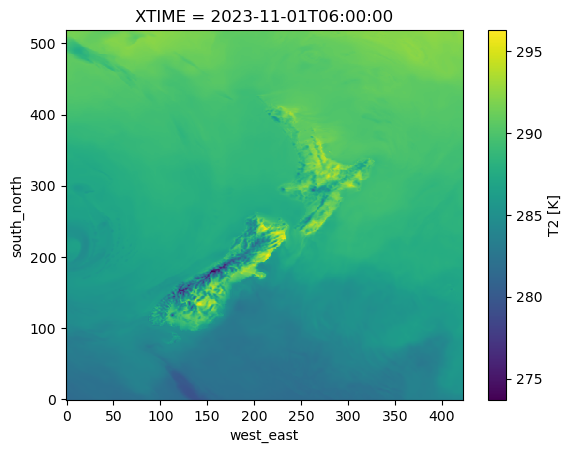

In [18]:
base_ds.T2.isel(Time=0).plot()

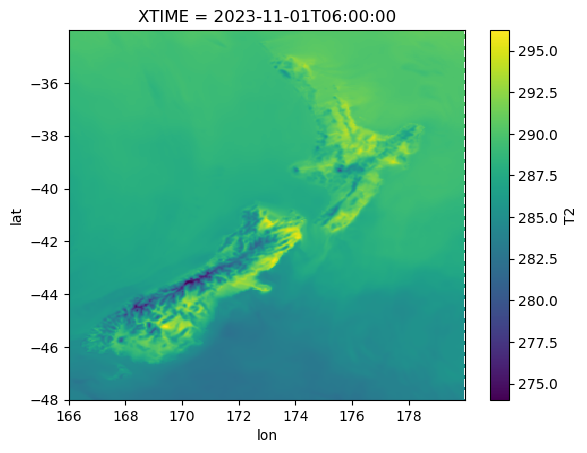

In [17]:
new_ds.T2.isel(Time=0).plot()

# New method

In [19]:
import xesmf as xe

In [42]:
ds = base_ds.rename({'XLONG': 'lon', 'XLAT': 'lat'})
ds

<xarray.Dataset>
Dimensions:  (Time: 12, south_north: 519, west_east: 423)
Coordinates:
    lat      (Time, south_north, west_east) float32 -49.67 -49.68 ... -30.7
    lon      (Time, south_north, west_east) float32 160.9 161.0 ... -178.0
    XTIME    (Time) datetime64[ns] 2023-11-01T06:00:00 ... 2023-11-02T11:00:00
Dimensions without coordinates: Time, south_north, west_east
Data variables:
    T2       (Time, south_north, west_east) float32 281.5 281.5 ... 293.3 293.3
    RAINNC   (Time, south_north, west_east) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    U10      (Time, south_north, west_east) float32 1.9 1.78 ... -6.042 -6.207
    V10      (Time, south_north, west_east) float32 -0.1563 -0.09277 ... -5.779
    PSFC     (Time, south_north, west_east) float32 1.014e+05 ... 1.021e+05
    SWDOWN   (Time, south_north, west_east) float32 387.2 386.1 ... 0.0 0.0
Attributes: (12/86)
    TITLE:                            OUTPUT FROM WRF V4.2.2 MODEL
    START_DATE:                      2023-11-01_00:00:00
    SIMULATION_START_DATE:           2023-11-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        424
    SOUTH-NORTH_GRID_DIMENSION:      520
    BOTTOM-TOP_GRID_DIMENSION:       51
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           22
    ISURBAN:                         19
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

In [24]:
ds_out = xr.Dataset({
    'lat': (['lat'], aux_raw_ds.latitude.values),
    'lon': (['lon'], aux_raw_ds.longitude.values),
})

In [26]:
regridder = xe.Regridder(ds.isel(Time=0), ds_out, "bilinear")

In [24]:
# regridder.to_netcdf()

'bilinear_519x423_350x350.nc'

In [27]:
new = regridder(ds)

In [28]:
new

<xarray.Dataset>
Dimensions:  (Time: 12, lat: 350, lon: 350)
Coordinates:
    XTIME    (Time) datetime64[ns] 2023-11-01T06:00:00 ... 2023-11-02T11:00:00
  * lat      (lat) float32 -47.98 -47.94 -47.9 -47.86 ... -34.1 -34.06 -34.02
  * lon      (lon) float32 166.0 166.1 166.1 166.1 ... 179.9 179.9 179.9 180.0
Dimensions without coordinates: Time
Data variables:
    T2       (Time, lat, lon) float32 284.1 284.1 284.0 ... 290.7 290.7 290.7
    RAINNC   (Time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    U10      (Time, lat, lon) float32 -3.338 -3.602 -3.789 ... -2.7 -2.785
    V10      (Time, lat, lon) float32 2.792 2.536 2.347 ... -5.265 -5.298 -5.265
    PSFC     (Time, lat, lon) float32 1.012e+05 1.012e+05 ... 1.021e+05
    SWDOWN   (Time, lat, lon) float32 310.4 310.1 309.7 309.3 ... 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

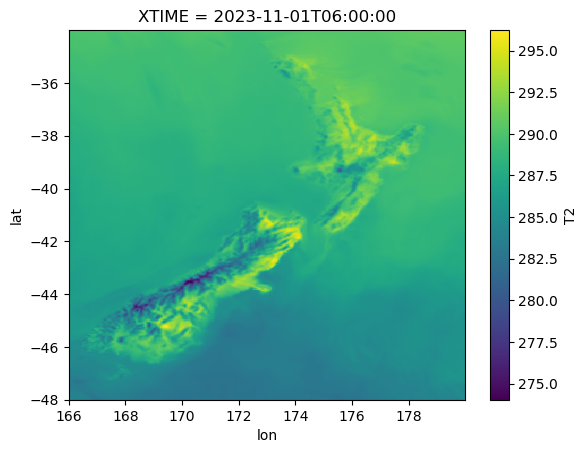

In [29]:
new.isel(Time=0).T2.plot()

In [30]:
new == new_ds

<xarray.Dataset>
Dimensions:  (Time: 12, lat: 350, lon: 350)
Coordinates:
    XTIME    (Time) datetime64[ns] 2023-11-01T06:00:00 ... 2023-11-02T11:00:00
  * lat      (lat) float32 -47.98 -47.94 -47.9 -47.86 ... -34.1 -34.06 -34.02
  * lon      (lon) float32 166.0 166.1 166.1 166.1 ... 179.9 179.9 179.9 180.0
Dimensions without coordinates: Time
Data variables:
    T2       (Time, lat, lon) bool True True True True ... True True True False
    RAINNC   (Time, lat, lon) bool True True True True ... True True True False
    U10      (Time, lat, lon) bool True True True True ... True True True False
    V10      (Time, lat, lon) bool True True True True ... True True True False
    PSFC     (Time, lat, lon) bool True True True True ... True True True False
    SWDOWN   (Time, lat, lon) bool True True True True ... True True True False